# Bike rental in Washington DC
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load and clean the data

### Load the data

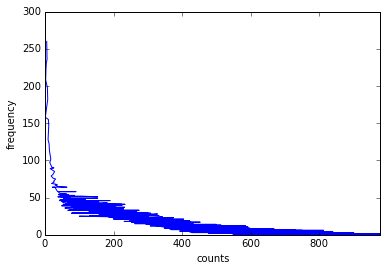

In [27]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
ax = bike_rentals['cnt'].value_counts().plot()
ax.set_xlabel('counts')
ax.set_ylabel('frequency')

### Correlation between columns

In [21]:
bike_rentals.corr().loc['cnt',:]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

We see that the only variables with correlation higher than 0.25 are hour, temp, atemp, humidity and year (though only slightly). Moreover, instant, casual and registered also show very strong correlation, but we decided to no tinclude it in our analysis.

### Transform the data
We add time labels morning, afternoon, evening, night to group the hours of the day and help the algorithm.

In [40]:
def assign_label(s_hour):
    hour_ranges = [[6, 12], 
                    [12, 18], 
                    [18, 24], 
                    [00, 6]]
    labels = s_hour.copy()
    labels[:] = np.nan
    for i in range(4):
        is_in_range = (s_hour >= hour_ranges[i][0]) & (s_hour < hour_ranges[i][1])
        labels[is_in_range] = (i+1)
    return labels

bike_rentals['time_label'] = assign_label(bike_rentals['hr'])

In [44]:
bike_rentals['time_label'].value_counts()

2.0    4375
3.0    4368
1.0    4360
4.0    4276
Name: time_label, dtype: int64

## Train the ML model
We will choose the MSE to evaluate the performance of our ML algorithm. We will train the model with separate train sets (80% of data) and evaluate its performance with the test set (20% of the data). We use the K-fold validation method with 5 splits, and me compare the average of the MSE over the splits as well as its STD.

In [54]:
from sklearn.model_selection import KFold

train_cols = [col for col in bike_rentals.columns if col not in ['instant', 'cnt', 'casual', 
                                                                 'registered', 'workingday', 
                                                                 'weekday', 'holiday', 'season', 
                                                                 'windspeed', 'dteday']]
kf = KFold(n_splits=5, random_state=14)
X = bike_rentals[train_cols]
y = bike_rentals['cnt']

### Linear regression

18809.531565190224 8482.763406816784


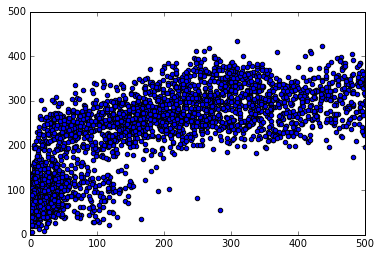

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

mse_ln = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    predictions = lr.predict(X_test)
    mse_value = mean_squared_error(y_test, predictions)
    mse_ln.append(mse_value)
mse_ln_mean = np.mean(mse_ln)
mse_ln_std= np.std(mse_ln)

print(mse_ln_mean, mse_ln_std)

# print the values vs predictions to get a visual reference
plt.scatter(y_test, predictions)
plt.xlim(0,500)
plt.ylim(0,500)

plt.show()

The error is OK, but we do not see a clear linear dependence between true and predicted values

### Decission tree

2 14789.168912983252 4843.184806473294
5 14669.491760613571 4843.665162484539
10 14656.255708690534 4901.521669699892
50 14616.791697350523 4821.628932252248
100 14569.993101611752 4851.1505354899155


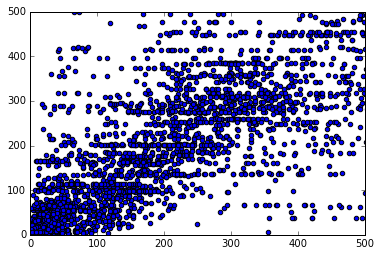

In [73]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error

mse_tr_mean = {}
mse_tr_std = {}
min_samples_list = [2, 5, 10, 50, 100]

for min_samples in min_samples_list:
    mse_tr = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        tr = DecisionTreeRegressor(min_samples_split=min_samples_list[2])
        tr.fit(X_train, y_train)
        
        predictions = tr.predict(X_test)
        mse_value = mean_squared_error(y_test, predictions)
        mse_tr.append(mse_value)
    mse_tr_mean[min_samples] = np.mean(mse_tr)
    mse_tr_std[min_samples] = np.std(mse_tr)

    print(min_samples, mse_tr_mean[min_samples], mse_tr_std[min_samples])

# print the values vs predictions to get a visual reference
plt.scatter(y_test, predictions)
plt.xlim(0,500)
plt.ylim(0,500)

plt.show()

This algorithm seems to work considerably better, even yhough the MSE is only a 25% smaller, the STD is almost half thatn in the Linera regression model.

### Random Forest

2 11555.530902666533 4857.06799784405
3 10405.855265137387 4101.279102330401
4 9975.117393487166 3787.060160345631
5 9840.772324992111 3767.7971731519983
6 9611.560366000385 3653.0715279413166
7 9873.36914782978 3572.177745972705
8 9800.961481028946 3591.1856770628456


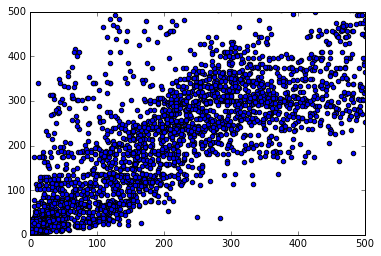

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mse_rf_mean = {}
mse_rf_std = {}
n_features_list = [2, 3, 4, 5, 6, 7, 8]

for n_features in n_features_list:
    mse_rf = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf = RandomForestRegressor(min_samples_split=50, max_features=n_features, random_state=3)
        rf.fit(X_train, y_train)
        
        predictions = rf.predict(X_test)
        mse_value = mean_squared_error(y_test, predictions)
        mse_rf.append(mse_value)
    mse_rf_mean[n_features] = np.mean(mse_rf)
    mse_rf_std[n_features] = np.std(mse_rf)

    print(n_features, mse_rf_mean[n_features], mse_rf_std[n_features])

# print the values vs predictions to get a visual reference
plt.scatter(y_test, predictions)
plt.xlim(0,500)
plt.ylim(0,500)

plt.show()

The results are quite satisfactory, Random Forest algorithm reduces by 33% the error respect to the decission trees results, as well as the STD. We saw that the min_sample_leaf does not affect much the results, but increasing the n_features we do however increase the accuracy.

## Conclusion
We saw that Random Forest preforms considerably better than the other two ML models tested. This is not surprising, since it is one of the more accurate ML methods despite its simplicity.